## Loading the Dataset

In [1]:
# Standard includes
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
# Useful module for dealing with the Gaussian density
from scipy.stats import norm, multivariate_normal 
# installing packages for interactive graphs
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider

In [2]:
# Load data set.
data = np.loadtxt('../Dataset/wine.data', delimiter=',')
# Names of features
featurenames = ['Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash','Magnesium', 'Total phenols', 
                'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 
                'OD280/OD315 of diluted wines', 'Proline']
# Split 178 instances into training set (trainx, trainy) of size 130 and test set (testx, testy) of size 48
np.random.seed(0)
perm = np.random.permutation(178)
trainx = data[perm[0:130],1:14]
trainy = data[perm[0:130],0]
testx = data[perm[130:178], 1:14]
testy = data[perm[130:178],0]

## Fitting a Gaussian to only one winery

In [3]:
# Fit a Gaussian to a data set using the selected features
def fit_gaussian(x, features):
    mu = np.mean(x[:,features], axis=0)
    covar = np.cov(x[:,features], rowvar=0, bias=1)
    return mu, covar

# Find the range within which an array of numbers lie, with a little buffer
def find_range(x):
    lower = min(x)
    upper = max(x)
    width = upper - lower
    lower = lower - 0.2 * width
    upper = upper + 0.2 * width
    return lower, upper

def plot_contours(mu, cov, x1g, x2g, col):
    rv = multivariate_normal(mean=mu, cov=cov)
    z = np.zeros((len(x1g),len(x2g)))
    for i in range(0,len(x1g)):
        for j in range(0,len(x2g)):
            z[j,i] = rv.logpdf([x1g[i], x2g[j]]) 
    sign, logdet = np.linalg.slogdet(cov)
    normalizer = -0.5 * (2 * np.log(6.28) + sign * logdet)
    for offset in range(1,4):
        plt.contour(x1g,x2g,z, levels=[normalizer - offset], colors=col, linewidths=2.0, linestyles='solid')

In [4]:
def two_features_plot(f1,f2,label):
    if f1 == f2: # we need f1 != f2
        print("Please choose different features for f1 and f2.")
        return  
    
    # Set up plot
    x1_lower, x1_upper = find_range(trainx[trainy==label,f1])
    x2_lower, x2_upper = find_range(trainx[trainy==label,f2])
    plt.xlim(x1_lower, x1_upper) # limit along x1-axis
    plt.ylim(x2_lower, x2_upper) # limit along x2-axis
    
    # Plot the training points along the two selected features
    plt.plot(trainx[trainy==label, f1], trainx[trainy==label, f2], 'ro')

    # Define a grid along each axis; the density will be computed at each grid point
    res = 200 # resolution
    x1g = np.linspace(x1_lower, x1_upper, res)
    x2g = np.linspace(x2_lower, x2_upper, res)

    # Now plot a few contour lines of the density
    mu, cov = fit_gaussian(trainx[trainy==label,:], [f1,f2])
    plot_contours(mu, cov, x1g, x2g, 'k')
    
    # Finally, display
    plt.xlabel(featurenames[f1], fontsize=14, color='red')
    plt.ylabel(featurenames[f2], fontsize=14, color='red')
    plt.title('Class ' + str(label), fontsize=14, color='blue')
    plt.show()

In [5]:
f1 = 0
f2 = 6
label = 1
mu, covar = fit_gaussian(trainx[trainy==label,:], [f1,f2])
print("Mean:\n" + str(mu))
print("Covariance matrix:\n" + str(covar))

Mean:
[13.78534884  2.99627907]
Covariance matrix:
[[0.23325279 0.07526874]
 [0.07526874 0.15240941]]


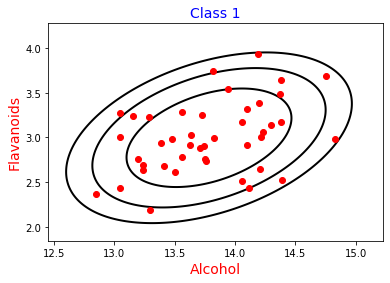

In [6]:
two_features_plot(f1,f2,label)

## Fitting a Gaussian to all three wineries

In [7]:
def fit_generative_model(x, y, features):
    k = 3 # number of classes
    d = len(features) # number of features
    mu = np.zeros((k+1,d)) # list of means
    covar = np.zeros((k+1,d,d)) # list of covariance matrices
    pi = np.zeros(k+1) # list of class weights
    for label in range(1,k+1):
        indices = (y==label)
        mu[label,:], covar[label,:,:] = fit_gaussian(x[indices,:], features)
        pi[label] = float(sum(indices))/float(len(y))
    return mu, covar, pi

In [8]:
def three_class_plot(f1,f2):
    if f1 == f2: # we need f1 != f2
        print("Please choose different features for f1 and f2.")
        return  
    
    # Set up plot
    x1_lower, x1_upper = find_range(trainx[:,f1])
    x2_lower, x2_upper = find_range(trainx[:,f2])
    plt.xlim(x1_lower, x1_upper) # limit along x1-axis
    plt.ylim(x2_lower, x2_upper) # limit along x2-axis
    
    # Plot the training points along the two selected features
    colors = ['r', 'k', 'g']
    for label in range(1,4):
        plt.plot(trainx[trainy==label,f1], trainx[trainy==label,f2], marker='o', ls='None', c=colors[label-1])

    # Define a grid along each axis; the density will be computed at each grid point
    res = 200 # resolution
    x1g = np.linspace(x1_lower, x1_upper, res)
    x2g = np.linspace(x2_lower, x2_upper, res)

    # Show the Gaussian fit to each class, using features f1,f2
    mu, covar, pi = fit_generative_model(trainx, trainy, [f1,f2])
    for label in range(1,4):
        gmean = mu[label,:]
        gcov = covar[label,:,:]
        plot_contours(gmean, gcov, x1g, x2g, colors[label-1])

    # Finally, display
    plt.xlabel(featurenames[f1], fontsize=14, color='red')
    plt.ylabel(featurenames[f2], fontsize=14, color='red')
    plt.title('Wine data', fontsize=14, color='blue')
    plt.show()

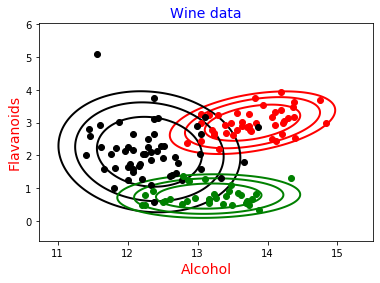

In [9]:
f1=0
f2=6
three_class_plot(f1,f2)

## Testing the model

In [10]:
# Now test the performance of a predictor based on a subset of features
def test_model(f1, f2):
    if f1 == f2: # need f1 != f2
        print("Please choose different features for f1 and f2.")
        return  
    features= [f1,f2]
    mu, covar, pi = fit_generative_model(trainx, trainy, features)
    
    k = 3 # Labels 1,2,...,k
    nt = len(testy) # Number of test points
    score = np.zeros((nt,k+1))
    for i in range(0,nt):
        for label in range(1,k+1):
            score[i,label] = np.log(pi[label]) + \
            multivariate_normal.logpdf(testx[i,features], mean=mu[label,:], cov=covar[label,:,:])
    predictions = np.argmax(score[:,1:4], axis=1) + 1
    # Finally, tally up score
    errors = np.sum(predictions != testy)
    #print("Test error using feature(s): ",)
    #for f in features:
    #    print("'" + featurenames[f] + "'" + " ",)
    #print
    #print("Errors: " + str(errors) + "/" + str(nt))# Now test the performance of a predictor based on a subset of features
    return(errors)

In [11]:
from itertools import combinations 

error=[]
comb = combinations(range(13), 2) 
for i in list(comb):
    error.append((i[0],i[1],test_model(i[0],i[1])))

In [12]:
error.sort(key=lambda x:x[2])
minerr=error[:5]

In [13]:
nt = len(testy) # Number of test points
for i in minerr:
    features=[i[0],i[1]]
    print("Test error using feature(s): ",)
    for f in features:
        print("'" + featurenames[f] + "'" + " ",)
    print
    print("Errors: " + str(i[2]) + "/" + str(nt))# Now test the performance of a predictor based on a subset of features
    print("=================================================================")

Test error using feature(s): 
'Flavanoids' 
'Color intensity' 
Errors: 3/48
Test error using feature(s): 
'Alcohol' 
'Flavanoids' 
Errors: 4/48
Test error using feature(s): 
'Flavanoids' 
'Hue' 
Errors: 4/48
Test error using feature(s): 
'Flavanoids' 
'Proline' 
Errors: 4/48
Test error using feature(s): 
'OD280/OD315 of diluted wines' 
'Proline' 
Errors: 4/48


## Decision Boundary

In [14]:
def show_decision_boundary(f1,f2):
    # Fit Gaussian to each class
    mu, covar, pi = fit_generative_model(trainx, trainy, [f1,f2])
    
    # Set up dimensions of plot
    x1_lower, x1_upper = find_range(trainx[:,f1])
    x2_lower, x2_upper = find_range(trainx[:,f2])
    plt.xlim([x1_lower,x1_upper])
    plt.ylim([x2_lower,x2_upper])

    # Plot points in training set
    colors = ['r', 'k', 'g']
    for label in range(1,4):
        plt.plot(trainx[trainy==label,f1], trainx[trainy==label,f2], marker='o', ls='None', c=colors[label-1])

    # Define a dense grid; every point in the grid will be classified according to the generative model
    res = 200
    x1g = np.linspace(x1_lower, x1_upper, res)
    x2g = np.linspace(x2_lower, x2_upper, res)

    # Declare random variables corresponding to each class density
    random_vars = {}
    for label in range(1,4):
        random_vars[label] = multivariate_normal(mean=mu[label,:],cov=covar[label,:,:])

    # Classify every point in the grid; these are stored in an array Z[]
    Z = np.zeros((len(x1g), len(x2g)))
    for i in range(0,len(x1g)):
        for j in range(0,len(x2g)):
            scores = []
            for label in range(1,4):
                scores.append(np.log(pi[label]) + random_vars[label].logpdf([x1g[i],x2g[j]]))
            Z[i,j] = np.argmax(scores) + 1

    # Plot the contour lines
    plt.contour(x1g,x2g,Z.T,3,cmap='seismic')
    
    # Finally, show the image
    plt.xlabel(featurenames[f1], fontsize=14, color='red')
    plt.ylabel(featurenames[f2], fontsize=14, color='red')
    plt.show()

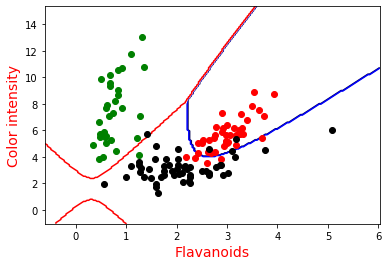

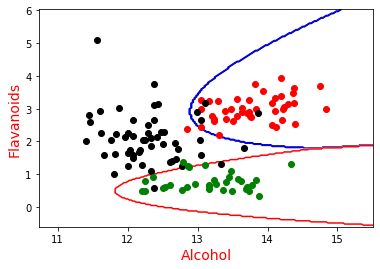

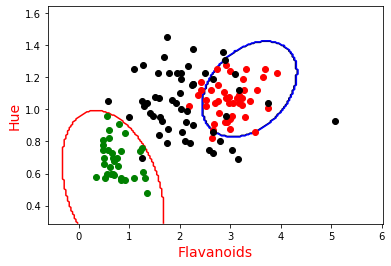

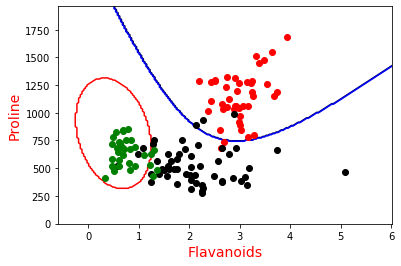

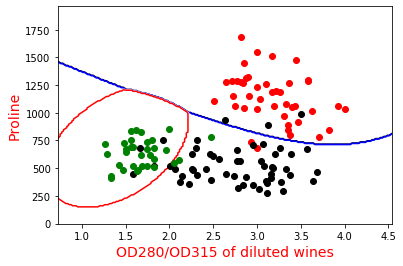

In [15]:
for i in minerr:
    show_decision_boundary(i[0],i[1])